In [1]:
import os
os.chdir('../')

from GenStudentMixtures.Mixture_Multivariate_Student_Generalized import MMST
from GenStudentMixtures.Multivariate_Student_Generalized import MST

from GenStudentMixtures.GenStudentMixtures import GenStudentMixtures

from pymanopt.solvers import ConjugateGradient, SteepestDescent

import numpy as np
from numpy.random import shuffle

from scipy.stats import ortho_group

import matplotlib.pyplot as plt

# Import r code for trimkmeans
import rpy2.robjects as robjects
import rpy2.robjects.numpy2ri
rpy2.robjects.numpy2ri.activate()

r = robjects.r
r['source']('TKM.R')
trimkmeans = robjects.globalenv['trimkmeans']

In [2]:
solver1 = ConjugateGradient(beta_rule='PolakRibiere', max_iterations=1000, verbosity=0)
solver2 = SteepestDescent(max_iterations=1000, verbosity=0)

## Sampling


### 3 clusters dim 2


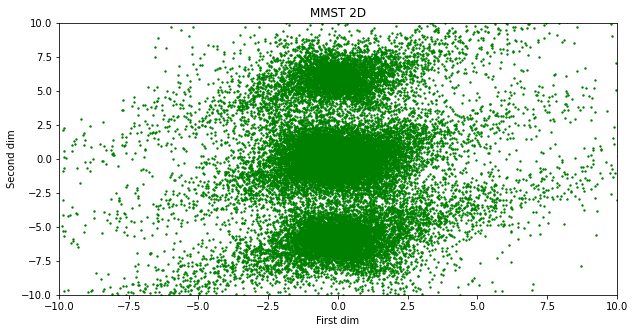

In [3]:
pi_23 = np.array([.3, .5, .2], dtype=np.float64)
mu_23 = np.array([[0, -6], [0, 0], [0, 6]], dtype=np.float64)
A_23 = np.ones((3, 2), dtype=np.float64)
angle = np.pi / 6
matRot_23 = [[np.cos(angle), -np.sin(angle)], [np.sin(angle), np.cos(angle)]]
D_23 = np.array([matRot_23, matRot_23, matRot_23], dtype=np.float64)
nu_23 = np.array([[1, 4], [2, 3], [1, 5]], dtype=np.float64)

gen_mix_23, _ = MMST(pi_23, mu_23, A_23, D_23, nu_23).sample(1000000)

plt.figure(figsize=(10, 5))

plt.scatter(gen_mix_23[:30000, 0], gen_mix_23[:30000, 1], s=1.9, c='green')

plt.xlim(-10, 10)
plt.xlabel('First dim')

plt.ylim(-10, 10)
plt.ylabel('Second dim')

plt.title('MMST 2D')
plt.show()

In [4]:
# Learning rates
gam = (1-10e-10)*np.array([k for k in range(1, len(gen_mix_23) + 1)]) ** (-6/10)

# Training
model_23 = GenStudentMixtures(3, solver1, max_iterations=3500)
model_23.fit(gen_mix_23, gam, 200)

 70%|███████████████████████████▎           | 3500/4999 [03:04<01:18, 18.98it/s]


In [5]:
print(pi_23, model_23.pi)

[0.3 0.5 0.2] [0.20049724 0.29921362 0.50028915]


In [6]:
permut_real2model = [1, 2, 0]

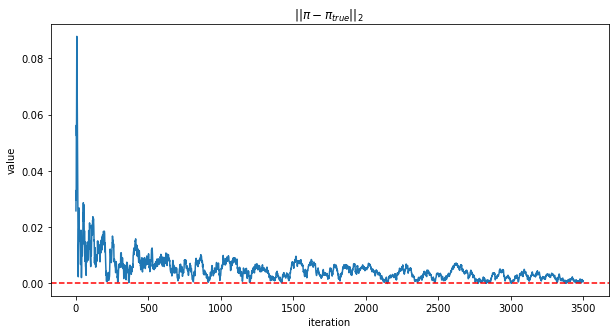

In [7]:
pi_curve = [np.linalg.norm(pi[permut_real2model] - pi_23, 2) for pi in model_23.pi_hist] 

plt.figure(figsize=(10, 5))
plt.plot(np.arange(len(pi_curve)), pi_curve)
plt.axhline(y = 0, color = 'r', linestyle = '--')

plt.xlabel('iteration')
plt.ylabel('value')
plt.title(r'$||\pi - \pi_{true}||_2$ ')
plt.show()

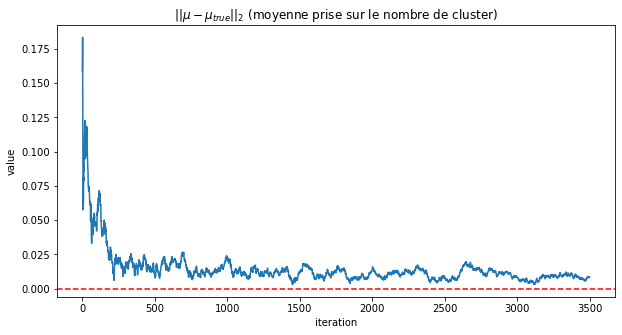

In [8]:
mu_curve = np.array([[np.linalg.norm(mu[permut_real2model][k]-mu_23[k], 2) for k in range(3)] for mu in model_23.mu_hist]).mean(axis=-1)

plt.figure(figsize=(10, 5))
plt.plot(np.arange(len(mu_curve)), mu_curve)
plt.axhline(y = 0, color = 'r', linestyle = '--')
plt.xlabel('iteration')
plt.ylabel('value')
plt.title(r'$||\mu - \mu_{true}||_2$ (moyenne prise sur le nombre de cluster)')
plt.show()

In [9]:
tmp = np.swapaxes(model_23.D, 1, 2) @ D_23 / np.max(np.abs(np.swapaxes(model_23.D, 1, 2) @ D_23),
                                                         axis=-1)[..., np.newaxis]
permute = np.logical_or(tmp == 1, tmp == -1)

A_permut_hist = [(permute @ A[...,np.newaxis]).squeeze(-1) for A in model_23.A_hist]
nu_permut_hist = [(permute @ nu[...,np.newaxis]).squeeze(-1) for nu in model_23.nu_hist]
D_permut_hist = [permute @ np.abs(D) for D in model_23.D_hist]

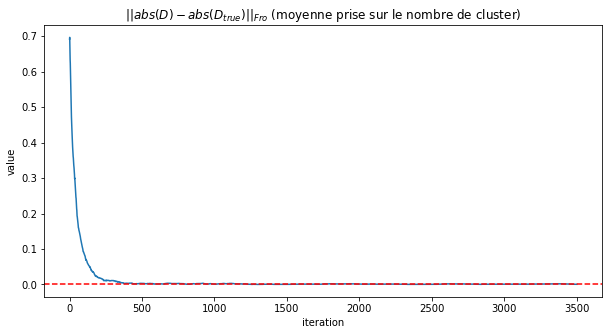

In [10]:
D_curve  = np.array([[np.linalg.norm(D[permut_real2model][k] - np.abs(D_23[k])) for k in range(3)] for D in D_permut_hist]).mean(axis=1)

plt.figure(figsize=(10, 5))
plt.plot(np.arange(len(D_curve)), D_curve)
plt.axhline(y = 0, color = 'r', linestyle = '--')
plt.xlabel('iteration')
plt.ylabel('value')
plt.title(r'$||abs(D) - abs(D_{true})||_{Fro}$ (moyenne prise sur le nombre de cluster)')
plt.show()

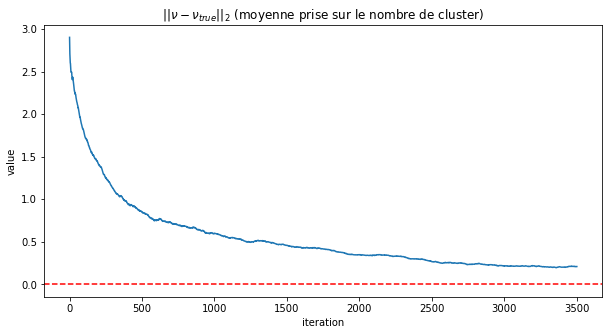

In [11]:
nu_curve = np.array([[np.linalg.norm(nu[permut_real2model][k]-nu_23[k], 2) for k in range(3)] for nu in nu_permut_hist]).mean(axis=-1)

plt.figure(figsize=(10, 5))
plt.plot(np.arange(len(nu_curve)), nu_curve)
plt.axhline(y = 0, color = 'r', linestyle = '--')
plt.xlabel('iteration')
plt.ylabel('value')
plt.title(r'$||\nu - \nu_{true}||_2$ (moyenne prise sur le nombre de cluster)')
plt.show()

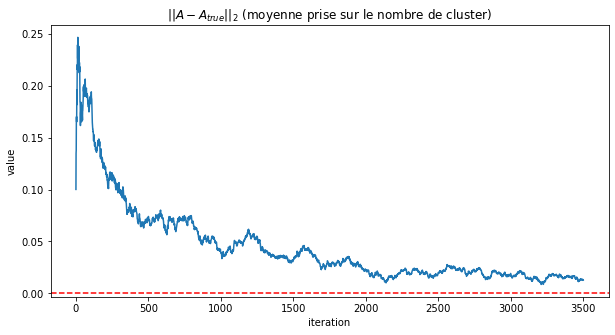

In [12]:
A_curve = np.array([[np.linalg.norm(A[permut_real2model][k]-A_23[k], 2) for k in range(3)] for A in A_permut_hist]).mean(axis=-1)

plt.figure(figsize=(10, 5))
plt.plot(np.arange(len(A_curve)), A_curve)
plt.axhline(y = 0, color = 'r', linestyle = '--')
plt.xlabel('iteration')
plt.ylabel('value')
plt.title(r'$||A - A_{true}||_2$ (moyenne prise sur le nombre de cluster)')
plt.show()

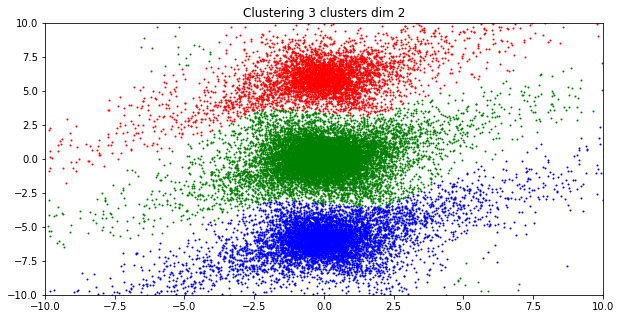

In [13]:
# clustering
cluster_lab = model_23.predict(gen_mix_23[:25000])

cdict = {0: 'red', 1: 'blue', 2: 'green'}

fig = plt.figure(figsize=(10, 5))

for g in np.unique(cluster_lab):
    ix = np.where(cluster_lab == g)
    plt.scatter(gen_mix_23[:,0][ix], gen_mix_23[:,1][ix], c = cdict[int(g)], label = int(g), s = 1)
plt.xlim(-10, 10)
plt.ylim(-10, 10)
plt.title('Clustering 3 clusters dim 2')

plt.show()

### 4 clusters 2 dims

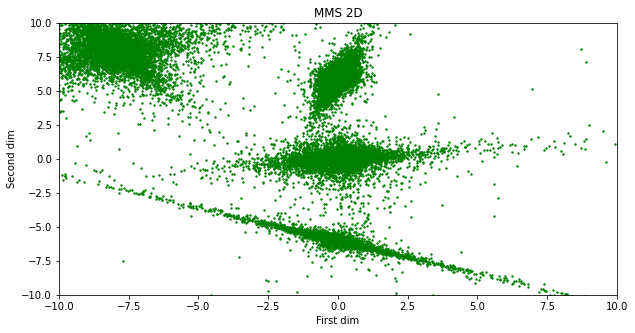

In [14]:
# pi_24 = np.array([.1, .2, .3, .4], dtype=np.float64)
pi_24 = np.array([.18, .2, .28, .34], dtype=np.float64)
mu_24 = np.array([[0, -6], [0, 0], [0, 6], [-8, 8]], dtype=np.float64)
angle = np.pi / 6
matRot_24 = [[np.cos(angle), -np.sin(angle)], [np.sin(angle), np.cos(angle)]]
matRot_24_2 = [[np.cos(np.pi/2), -np.sin(np.pi/2)], [np.sin(np.pi/2), np.cos(np.pi/2)]]
#D_24 = np.array([matRot_24, matRot_24, matRot_24, matRot_24_2], dtype=np.float64)
D_24 = np.array([ortho_group.rvs(dim=2), ortho_group.rvs(dim=2), ortho_group.rvs(dim=2), ortho_group.rvs(dim=2)], dtype=np.float64)
A_24 = np.array([[.2, .01], [.1, .5], [.05, .2], [.18, .9]], dtype=np.float64)
nu_24 = np.array([[1, 2], [1.5, 2], [6, 2], [0.5, 3]], dtype=np.float64)

gen_mix_24, _ = MMST(pi_24, mu_24, A_24, D_24, nu_24).sample(1000000)

# real estimation 
res = trimkmeans(gen_mix_24[:400], 4)
clusters, mu_pred = res[0], res[1]

pi_pred = np.array([(clusters == k).sum()  / (clusters != 0).sum() for k in range(1, 5)], dtype=np.float64)
    
# D_pred = np.array([np.eye(2), np.eye(2), np.eye(2), [[0, -1], [1, 0]]], dtype=np.float64)
D_pred = np.array([ortho_group.rvs(dim=2), ortho_group.rvs(dim=2), ortho_group.rvs(dim=2), ortho_group.rvs(dim=2)], dtype=np.float64)
# A_pred = np.ones(A_24.shape, dtype=np.float64)
A_pred = np.random.uniform(.1, 3, size=A_24.shape)
nu_pred = np.random.uniform(1, 4, size=nu_24.shape) 

plt.figure(figsize=(10, 5))

plt.scatter(gen_mix_24[:30000, 0], gen_mix_24[:30000, 1], s=1.9, c='green')

plt.xlim(-10, 10)
plt.xlabel('First dim')

plt.ylim(-10, 10)
plt.ylabel('Second dim')

plt.title('MMS 2D')
plt.show()

In [16]:
# Learning rates
gam = (1-10e-10)*np.array([k for k in range(1, len(gen_mix_24) + 1)]) ** (-6/10)

# Training
model_24 = GenStudentMixtures(4, solver1, max_iterations=3500)
model_24.fit(gen_mix_24, gam, 200)

 70%|███████████████████████████▎           | 3500/4999 [03:14<01:23, 17.95it/s]


In [17]:
print(pi_24, model_24.pi)

[0.18 0.2  0.28 0.34] [0.18217449 0.2785323  0.19878082 0.34051239]


In [18]:
permut_real2model = [0, 2, 1, 3]

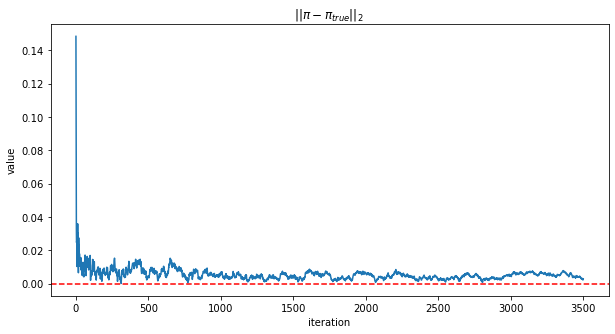

In [19]:
pi_curve = [np.linalg.norm(pi[permut_real2model] - pi_24, 2) for pi in model_24.pi_hist] 

plt.figure(figsize=(10, 5))
plt.plot(np.arange(len(pi_curve)), pi_curve)
plt.axhline(y = 0, color = 'r', linestyle = '--')

plt.xlabel('iteration')
plt.ylabel('value')
plt.title(r'$||\pi - \pi_{true}||_2$ ')
plt.show()

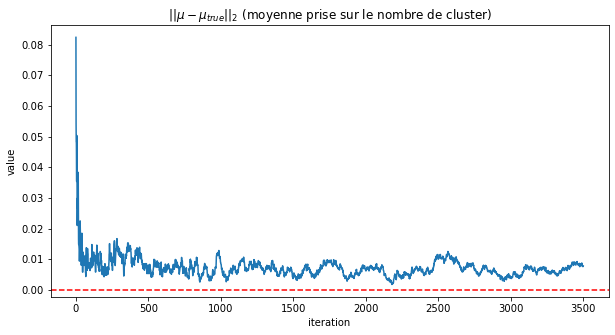

In [20]:
mu_curve = np.array([[np.linalg.norm(mu[permut_real2model][k]-mu_24[k], 2) for k in range(3)] for mu in model_24.mu_hist]).mean(axis=-1)

plt.figure(figsize=(10, 5))
plt.plot(np.arange(len(mu_curve)), mu_curve)
plt.axhline(y = 0, color = 'r', linestyle = '--')
plt.xlabel('iteration')
plt.ylabel('value')
plt.title(r'$||\mu - \mu_{true}||_2$ (moyenne prise sur le nombre de cluster)')
plt.show()

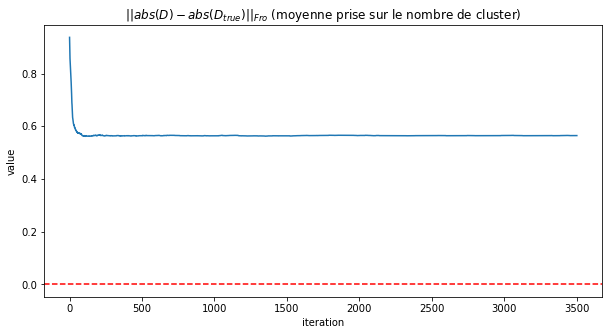

In [21]:
D_curve  = np.array([[np.linalg.norm(np.abs(D[permut_real2model][k]) - np.abs(D_24[k])) for k in range(3)] for D in model_24.D_hist]).mean(axis=1)

plt.figure(figsize=(10, 5))
plt.plot(np.arange(len(D_curve)), D_curve)
plt.axhline(y = 0, color = 'r', linestyle = '--')
plt.xlabel('iteration')
plt.ylabel('value')
plt.title(r'$||abs(D) - abs(D_{true})||_{Fro}$ (moyenne prise sur le nombre de cluster)')
plt.show()

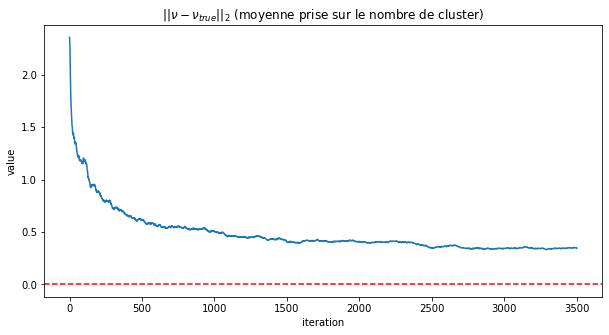

In [22]:
nu_curve = np.array([[np.linalg.norm(nu[permut_real2model][k]-nu_24[k], 2) for k in range(3)] for nu in model_24.nu_hist]).mean(axis=-1)

plt.figure(figsize=(10, 5))
plt.plot(np.arange(len(nu_curve)), nu_curve)
plt.axhline(y = 0, color = 'r', linestyle = '--')
plt.xlabel('iteration')
plt.ylabel('value')
plt.title(r'$||\nu - \nu_{true}||_2$ (moyenne prise sur le nombre de cluster)')
plt.show()

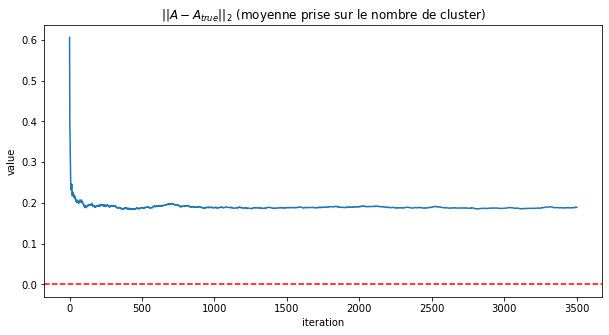

In [23]:
A_curve = np.array([[np.linalg.norm(A[permut_real2model][k]-A_24[k], 2) for k in range(3)] for A in model_24.A_hist]).mean(axis=-1)

plt.figure(figsize=(10, 5))
plt.plot(np.arange(len(A_curve[A_curve < 20])), A_curve[A_curve < 20])
plt.axhline(y = 0, color = 'r', linestyle = '--')
plt.xlabel('iteration')
plt.ylabel('value')
plt.title(r'$||A - A_{true}||_2$ (moyenne prise sur le nombre de cluster)')
plt.show()

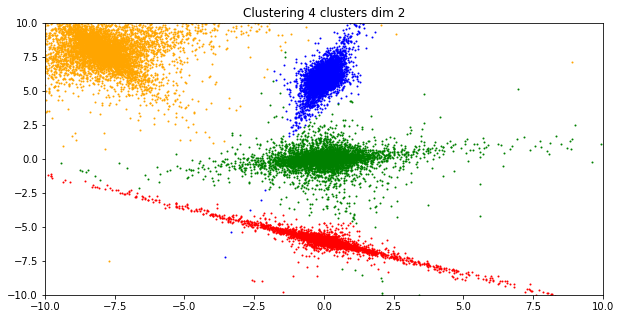

In [24]:
cluster_lab = model_24.predict(gen_mix_24[:25000])

cdict = {0: 'red', 1: 'blue', 2: 'green', 3: 'orange'}

fig = plt.figure(figsize=(10, 5))

for g in np.unique(cluster_lab):
    ix = np.where(cluster_lab == g)
    plt.scatter(gen_mix_24[:,0][ix], gen_mix_24[:,1][ix], c = cdict[int(g)], label = int(g), s = 1)
plt.xlim(-10, 10)
plt.ylim(-10, 10)
plt.title('Clustering 4 clusters dim 2')
plt.show()

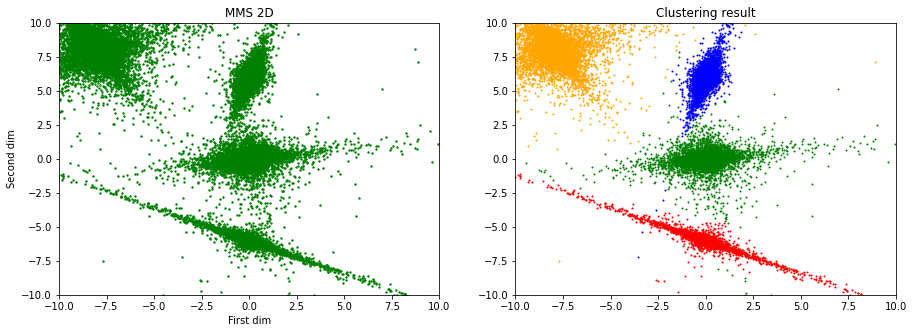

In [25]:
figure = plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.scatter(gen_mix_24[:30000, 0], gen_mix_24[:30000, 1], s=1.9, c='green')
plt.xlim(-10, 10)
plt.xlabel('First dim')
plt.ylim(-10, 10)
plt.ylabel('Second dim')
plt.title('MMS 2D')

plt.subplot(1, 2, 2)
for g in np.unique(cluster_lab):
    ix = np.where(cluster_lab == g)
    plt.scatter(gen_mix_24[:,0][ix], gen_mix_24[:,1][ix], c = cdict[int(g)], label = int(g), s = 1)
plt.xlim(-10, 10)
plt.ylim(-10, 10)
plt.title('Clustering result')
plt.savefig('res_1.eps', format='eps')
plt.show()

### 3 clusters 3 dims


In [ ]:
#3D mixtures
pi_33 = np.array([.3, .5, .2], dtype=np.float64)
mu_33 = np.array([[0, -6, 0], [0, 0, 0], [0, 6, 0]], dtype=np.float64)
angle = np.pi / 6
matRot_33 = [[1, 0, 0], [0, np.cos(angle), -np.sin(angle)], [0, np.sin(angle), np.cos(angle)]]
D_33 = np.array([matRot_33, matRot_33, matRot_33], dtype=np.float64)
A_33 = np.ones((3, 3), dtype=np.float64)
nu_33 = np.array([[1, 2, 3], [1, 2, 3], [1, 2, 3]], dtype=np.float64)

gen_mix_33, _ = MMST(pi_33, mu_33, A_33, D_33, nu_33).sample(1000000)

fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(projection='3d')

ax.scatter(gen_mix_33[:30000, 0], gen_mix_33[:30000, 1], gen_mix_33[:30000, 2], s=1, c='green')
ax.set_xlim(-10, 10)
ax.set_ylim(-10, 10)
ax.set_zlim(-10, 10)

ax.set_title("MMST 3D")

ax.set_xlabel("First dim")
ax.set_ylabel("Second dim")
ax.set_zlabel("Third dim")

plt.show()

res = trimkmeans(gen_mix_33[:400], 3)
clusters, mu_pred = res[0], res[1]

pi_pred = np.array([(clusters == k).sum()  / (clusters != 0).sum() for k in range(1, 4)], dtype=np.float64)
D_pred = np.array([np.eye(3), np.eye(3), np.eye(3)], dtype=np.float64)
A_pred = np.ones(A_33.shape, dtype=np.float64)
nu_pred = np.ones(nu_33.shape, dtype=np.float64)


In [ ]:
# Learning rates
gam = (1-10e-10)*np.array([k for k in range(1, len(gen_mix_33) + 1)]) ** (-6/10)

# Training
model_33 = GenStudentMixtures(pi_pred, mu_pred, A_pred, D_pred, nu_pred, solver1, max_iterations=3500)
model_33.fit(gen_mix_33, gam, 100)

In [ ]:
print(pi_33, model_33.pi)

In [ ]:
permut_real2model = [0, 2, 1]

In [ ]:
pi_curve = [np.linalg.norm(pi[permut_real2model] - pi_33, 2) for pi in model_33.pi_hist] 

plt.figure(figsize=(10, 5))
plt.plot(np.arange(len(pi_curve)), pi_curve)
plt.axhline(y = 0, color = 'r', linestyle = '--')
plt.xlabel('iteration')
plt.ylabel('value')
plt.title(r'$||\pi - \pi_{true}||_2$ ')
plt.show()

In [ ]:
mu_curve = np.array([[np.linalg.norm(mu[permut_real2model][k]-mu_33[k], 2) for k in range(3)] for mu in model_33.mu_hist]).mean(axis=-1)

plt.figure(figsize=(10, 5))
plt.plot(np.arange(len(mu_curve)), mu_curve)
plt.axhline(y = 0, color = 'r', linestyle = '--')
plt.xlabel('iteration')
plt.ylabel('value')
plt.title(r'$||\mu - \mu_{true}||_2$ (moyenne prise sur le nombre de cluster)')
plt.show()

In [ ]:
tmp = np.swapaxes(model_33.D, 1, 2) @ D_33 / np.max(np.abs(np.swapaxes(model_33.D, 1, 2) @ D_33),
                                                         axis=-1)[..., np.newaxis]
permute = np.logical_or(tmp == 1, tmp == -1)

A_permut_hist = [(permute @ A[...,np.newaxis]).squeeze(-1) for A in model_33.A_hist]
nu_permut_hist = [(permute @ nu[...,np.newaxis]).squeeze(-1) for nu in model_33.nu_hist]
D_permut_hist = [permute @ np.abs(D) for D in model_33.D_hist]

In [ ]:
D_curve  = np.array([[np.linalg.norm(D[permut_real2model][k] - np.abs(D_33[k])) for k in range(3)] for D in D_permut_hist]).mean(axis=1)

plt.figure(figsize=(10, 5))
plt.plot(np.arange(len(D_curve)), D_curve)
plt.axhline(y = 0, color = 'r', linestyle = '--')
plt.xlabel('iteration')
plt.ylabel('value')
plt.title(r'$||abs(D) - abs(D_{true})||_{Fro}$ (moyenne prise sur le nombre de cluster)')
plt.show()

In [ ]:
nu_curve = np.array([[np.linalg.norm(nu[permut_real2model][k]-nu_33[k], 2) for k in range(3)] for nu in nu_permut_hist]).mean(axis=-1)

plt.figure(figsize=(10, 5))
plt.plot(np.arange(len(nu_curve)), nu_curve)
plt.axhline(y = 0, color = 'r', linestyle = '--')
plt.xlabel('iteration')
plt.ylabel('value')
plt.title(r'$||\nu - \nu_{true}||_2$ (moyenne prise sur le nombre de cluster)')
plt.show()

In [ ]:
A_curve = np.array([[np.linalg.norm(A[permut_real2model][k]-A_33[k], 2) for k in range(3)] for A in A_permut_hist]).mean(axis=-1)

plt.figure(figsize=(10, 5))
plt.plot(np.arange(len(A_curve[A_curve < 20])), A_curve[A_curve < 20])
plt.axhline(y = 0, color = 'r', linestyle = '--')
plt.xlabel('iteration')
plt.ylabel('value')
plt.title(r'$||A - A_{true}||_2$ (moyenne prise sur le nombre de cluster)')
plt.show()

In [ ]:
cluster_lab = model_33.predict(gen_mix_33[:25000])

cdict = {0: 'red', 1: 'blue', 2: 'green'}

fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(projection='3d')
for g in np.unique(cluster_lab):
    ix = np.where(cluster_lab == g)
    ax.scatter(gen_mix_33[:,0][ix], gen_mix_33[:,1][ix], gen_mix_33[:,2][ix], c = cdict[int(g)], label = int(g), s = 1)
ax.legend()
ax.set_xlim(-10, 10)
ax.set_ylim(-10, 10)
ax.set_zlim(-10, 10)
ax.set_title('Clustering 3 clusters dim 3')

plt.show()

### 4 clusters 3 dims

In [ ]:
#3D mixtures
pi_34 = np.array([.18, .2, .28, .34], dtype=np.float64)
mu_34 = np.array([[0, -6, 0], [0, 0, 0], [0, 6, 0], [6, 0, 0]], dtype=np.float64)
angle = np.pi / 6
matRot_34 = [[1, 0, 0], [0, np.cos(angle), -np.sin(angle)], [0, np.sin(angle), np.cos(angle)]]
D_34 = np.array([matRot_34, matRot_34, matRot_34, matRot_34], dtype=np.float64)
A_34 =  np.array([[1, 1, 1], [1.02, 0.7, 0.5], [0.01, 0.2, 1], [0.01, 0.08, 0.9]], dtype=np.float64)
nu_34 = np.array([[1, 2, 5], [1, 2, 5], [1, 2, 5], [1, 2, 5]], dtype=np.float64)

gen_mix_34, _ = MMST(pi_34, mu_34, A_34, D_34, nu_34).sample(1000000)

res = trimkmeans(gen_mix_34[:400], 4)
clusters, mu_pred = res[0], res[1]

pi_pred = np.array([(clusters == k).sum()  / (clusters != 0).sum() for k in range(1, 5)], dtype=np.float64)
D_pred = np.array([np.eye(3), np.eye(3), np.eye(3), np.eye(3)], dtype=np.float64)
A_pred = np.ones(A_34.shape, dtype=np.float64)
nu_pred = np.ones(nu_34.shape, dtype=np.float64)

fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(projection='3d')

ax.scatter(gen_mix_34[:30000, 0], gen_mix_34[:30000, 1], gen_mix_34[:30000, 2], s=1, c='green')
ax.set_xlim(-10, 10)
ax.set_ylim(-10, 10)
ax.set_zlim(-10, 10)

ax.set_title("MMST 3D")

ax.set_xlabel("First dim")
ax.set_ylabel("Second dim")
ax.set_zlabel("Third dim")

plt.show()

In [ ]:
# Training
model_34 = GenStudentMixtures(pi_pred, mu_pred, A_pred, D_pred, nu_pred, solver1, max_iterations=3500)
model_34.fit(gen_mix_34, gam, 200)

In [ ]:
print(pi_34, model_34.pi)

In [ ]:
permut_real2model = [1, 3, 2, 0]

In [ ]:
pi_curve = [np.linalg.norm(pi[permut_real2model] - pi_34, 2) for pi in model_34.pi_hist] 

plt.figure(figsize=(10, 5))
plt.plot(np.arange(len(pi_curve)), pi_curve)
plt.axhline(y = 0, color = 'r', linestyle = '--')
plt.xlabel('iteration')
plt.ylabel('value')
plt.title(r'$||\pi - \pi_{true}||_2$ ')
plt.show()

In [ ]:
mu_curve = np.array([[np.linalg.norm(mu[permut_real2model][k]-mu_34[k], 2) for k in range(3)] for mu in model_34.mu_hist]).mean(axis=-1)

plt.figure(figsize=(10, 5))
plt.plot(np.arange(len(mu_curve)), mu_curve)
plt.axhline(y = 0, color = 'r', linestyle = '--')
plt.xlabel('iteration')
plt.ylabel('value')
plt.title(r'$||\mu - \mu_{true}||_2$ (moyenne prise sur le nombre de cluster)')
plt.show()

In [ ]:
tmp = np.swapaxes(model_34.D, 1, 2) @ D_34 / np.max(np.abs(np.swapaxes(model_34.D, 1, 2) @ D_34),
                                                         axis=-1)[..., np.newaxis]
permute = np.logical_or(tmp == 1, tmp == -1)

A_permut_hist = [(permute @ A[...,np.newaxis]).squeeze(-1) for A in model_34.A_hist]
nu_permut_hist = [(permute @ nu[...,np.newaxis]).squeeze(-1) for nu in model_34.nu_hist]
D_permut_hist = [permute @ np.abs(D) for D in model_34.D_hist]

In [ ]:
D_curve  = np.array([[np.linalg.norm(D[permut_real2model][k] - np.abs(D_34[k])) for k in range(3)] for D in D_permut_hist]).mean(axis=1)

plt.figure(figsize=(10, 5))
plt.plot(np.arange(len(D_curve)), D_curve)
plt.axhline(y = 0, color = 'r', linestyle = '--')
plt.xlabel('iteration')
plt.ylabel('value')
plt.title(r'$||abs(D) - abs(D_{true})||_{Fro}$ (moyenne prise sur le nombre de cluster)')
plt.show()

In [ ]:
nu_curve = np.array([[np.linalg.norm(nu[permut_real2model][k]-nu_34[k], 2) for k in range(3)] for nu in nu_permut_hist]).mean(axis=-1)

plt.figure(figsize=(10, 5))
plt.plot(np.arange(len(nu_curve)), nu_curve)
plt.axhline(y = 0, color = 'r', linestyle = '--')
plt.xlabel('iteration')
plt.ylabel('value')
plt.title(r'$||\nu - \nu_{true}||_2$ (moyenne prise sur le nombre de cluster)')
plt.show()

In [ ]:
A_curve = np.array([[np.linalg.norm(A[permut_real2model][k]-A_34[k], 2) for k in range(3)] for A in A_permut_hist]).mean(axis=-1)

plt.figure(figsize=(10, 5))
plt.plot(np.arange(len(A_curve[A_curve < 20])), A_curve[A_curve < 20])
plt.axhline(y = 0, color = 'r', linestyle = '--')
plt.xlabel('iteration')
plt.ylabel('value')
plt.title(r'$||A - A_{true}||_2$ (moyenne prise sur le nombre de cluster)')
plt.show()

In [ ]:
cluster_lab = model_34.predict(gen_mix_34[:25000])

cdict = {0: 'red', 1: 'blue', 2: 'green', 3:'orange'}

fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(projection='3d')

for g in np.unique(cluster_lab):
    ix = np.where(cluster_lab == g)
    ax.scatter(gen_mix_34[:,0][ix], gen_mix_34[:,1][ix], gen_mix_34[:,2][ix], c = cdict[int(g)], label = int(g), s = 1)
ax.legend()
ax.set_xlim(-10, 10)
ax.set_ylim(-10, 10)
ax.set_zlim(-10, 10)
ax.set_title('Clustering 4 clusters dim 3')

plt.show()

In [ ]:
pi_3_14 = np.random.randint(0, 100, 14)
pi_3_14 = pi_3_14 / pi_3_14.sum()
mu_3_14 = np.random.uniform(-100, 100, (14, 3))
D_3_14 = np.array([ortho_group.rvs(dim=3)] * 14, dtype=np.float64)
A_3_14 = np.random.uniform(.1, 10, (14, 3))
nu_3_14 = np.random.uniform(.1, 5, (14, 3))

gen_mix_3_14, labels = MMST(pi_3_14, mu_3_14, A_3_14, D_3_14, nu_3_14).sample(1000000)

In [ ]:
res = trimkmeans(gen_mix_3_14[:300], 14)
clusters, mu_pred = res[0], res[1]

pi_pred = np.array([(clusters == k).sum()  / (clusters != 0).sum() for k in range(1, 15)], dtype=np.float64)

D_pred = np.array([np.eye(3)] * 14, dtype=np.float64)
A_pred = np.ones(A_3_14.shape, dtype=np.float64)
nu_pred = np.ones(nu_3_14.shape, dtype=np.float64)

In [ ]:
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(projection='3d')

ax.scatter(gen_mix_3_14[:30000, 0], gen_mix_3_14[:30000, 1], gen_mix_3_14[:30000, 2], s=1, c='green')
ax.set_xlim(-100, 100)
ax.set_ylim(-100, 100)
ax.set_zlim(-100, 100)

ax.set_title("MMST 3D")

ax.set_xlabel("First dim")
ax.set_ylabel("Second dim")
ax.set_zlabel("Third dim")

plt.show()

In [ ]:
# Learning rates
gam = (1-10e-10)*np.array([k for k in range(1, len(gen_mix_3_14) + 1)]) ** (-6/10)

# Training
model_3_14 = GenStudentMixtures(pi_pred, mu_pred, A_pred, D_pred, nu_pred, solver1, max_iterations=3500)
model_3_14.fit(gen_mix_3_14, gam, 200)

In [ ]:
model_3_14.pi

In [ ]:
pi_3_14

In [ ]:
cluster_lab = model_3_14.predict(gen_mix_3_14[:25000])

cdict = {0: 'red', 1: 'blue', 2: 'green', 3:'orange', 5:'black', 6:'grey', 7:'cyan', 8:'darkgreen', 9:'darkblue', 10:'magenta', 11:'purple', 12:'pink', 13:'brown', 14:'lime', 4:'navy'}

fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(projection='3d')

for g in np.unique(cluster_lab):
    ix = np.where(cluster_lab == g)
    ax.scatter(gen_mix_3_14[:,0][ix], gen_mix_3_14[:,1][ix], gen_mix_3_14[:,2][ix], c = cdict[int(g)], label = int(g), s = 1)
ax.legend()
ax.set_xlim(-100, 100)
ax.set_ylim(-100, 100)
ax.set_zlim(-100, 100)
ax.set_title('Clustering 4 clusters dim 3')

plt.show()